<a href="https://colab.research.google.com/github/godfather-is-me/GANs-MNIST/blob/main/GANs_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem

- We are building a generative adversarial network to distinguish between numbers as provided in the MNIST dataset
- Fake number images created by the generator as compared to real images to synthesize more data
- Most of the code has been adopted from TF 2.0 documentation: https://www.tensorflow.org/beta/tutorials/generative/dcgan


## Import libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow-gpu==2.0.1

In [2]:
!pip install imageio

import glob
import imageio

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import os
import PIL
import time

from tensorflow.keras import layers
from IPython import display

import tensorflow as tf

## Import datasets and normalization

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

print(train_images.shape)
print(train_labels.shape)

(60000, 28, 28)
(60000,)


In [4]:
train_images = train_images.reshape(train_images.shape[0], 28 , 28, 1).astype('float32')
train_images.shape

(60000, 28, 28, 1)

In [5]:
train_images = (train_images - 127.5) / 127.5   # Normalize images to [-1, 1]

In [6]:
# Constants
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [7]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Visualize the dataset

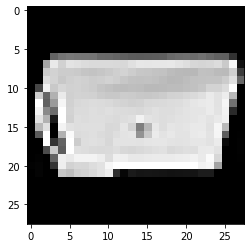

In [8]:
plt.imshow(train_images[110].reshape((28, 28)), cmap='gray')

## Build the generator

- To take in random noise signal and output images
- The goal is simply to generate fake images that are similar to the real ones
- The objective is to fool the discriminator
- Uses Conv2DTranspose (upsampling) layers to create an image from a seed of noise
- The seed is fed to a dense layers and upsampled several times until the final image size of 28x28x1 is achieved

In [9]:
def generator_model():
  model = tf.keras.Sequential()

  # First/Input layer
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))

  # Second layer
  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # Third layer
  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # Final layer
  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

  model.summary()

  return model

In [10]:
generator = generator_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [11]:
# Let's test it with a random noise seed and see the output

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

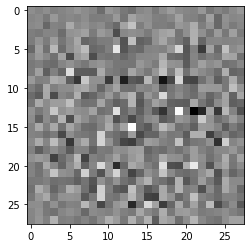

In [12]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Build the discriminator

- Trained to perform basic classification task

In [13]:
def discriminator_model():
  model = tf.keras.Sequential()

  # First layer
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.2))

  # Second layer
  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.2))

  model.add(layers.Flatten())

  # Third layer - First dense
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.BatchNormalization())

  # Fourth layer
  model.add(layers.Dense(1))

  model.summary()

  return model

In [14]:
disc = discriminator_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [15]:
# Checking if the discriminator classifies something with the dummy image
decision = disc(generated_image)
print(decision)

tf.Tensor([[-0.00088036]], shape=(1, 1), dtype=float32)


## Define loss function for both networks

In [16]:
# Computes the loss which is simply the difference between the model predictions and the true label
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
# Discriminator loss is able to distinguish between real and fake images by
# comparing the binary classes of the two

def disc_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss # Sum of both losses
  return total_loss

In [18]:
# The generator loss quantifies how well it was able to trick the discriminator
# Here we compare the discriminator's decisions on the generated images to an array of 1s

def gen_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
# Optimizers
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

In [20]:
# Checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer = gen_optimizer,
    discriminator_optimizer = disc_optimizer,
    generator = generator,
    discriminator = disc
    )

## Train the model

In [21]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # Call the generator and feed the noise
    generated_images = generator(noise, training=True)

    # Pass the fake and real ones to discriminator to perform classification
    real_output = disc(images, training=True)
    fake_output = disc(generated_images, training=True)

    # Calculate the loss for both the generator and discriminator
    g_loss = gen_loss(fake_output)
    d_loss = disc_loss(real_output, fake_output)

  # Calculate the gradient of the losses
  generator_gradient = gen_tape.gradient(g_loss, generator.trainable_variables)
  discriminator_gradient = disc_tape.gradient(d_loss, disc.trainable_variables)

  # Apply optimizer and update weights
  gen_optimizer.apply_gradients(zip(generator_gradient, generator.trainable_variables))
  disc_optimizer.apply_gradients(zip(discriminator_gradient, disc.trainable_variables))

In [23]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)

    # Save model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix= checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [24]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

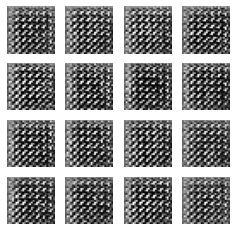

CPU times: user 9min 19s, sys: 1min 11s, total: 10min 31s
Wall time: 41min 1s


In [25]:
%%time
train(train_dataset, EPOCHS)

In [26]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [28]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch{:4d}.png'.format(epoch_no))


display_image(EPOCHS)

FileNotFoundError: ignored